# Estimating H_0

The distance estimations to standard(ized) candles will give us answers to many questions. In fact, this is how we realized that our Universe is accelerating in its expansion. In this part we would like to obtain the present expansion velocity - the Hubble constant using Supernova (SNIa) data sets from Supernova Cosmology Project website http://supernova.lbl.gov/Union/. 

The distance measurements are not trivial in cosmology. Our trivial understanding of distances are valid only upto 0th order - H_0. In the first order, we have to go beyond the astrophysical notion of distances and include cosmological aspects to it. 

First, we shall calculate H_0 from the simple Hubble-Lemaitre Law.  

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

Let us take Absolute Magnitude M(with systematics) as -19.3081547178 for all SNIa - standard candles

In [6]:
# We import data
file1 = open('sn.txt', 'r')
Lines = file1.readlines()
 
z = []
distance_mod = []

for line in Lines:
    x = line.split()
    if float(x[1]) < 0.1:
        z.append(float(x[1]))
        distance_mod.append(float(x[2]))

# Calculating Distance from Hubble Lemaitre Law with H_0 = 71
z = np.array(z)
distance_mod = np.array(distance_mod)

c = 3 * 1e5
distance = 71 * distance_mod / c

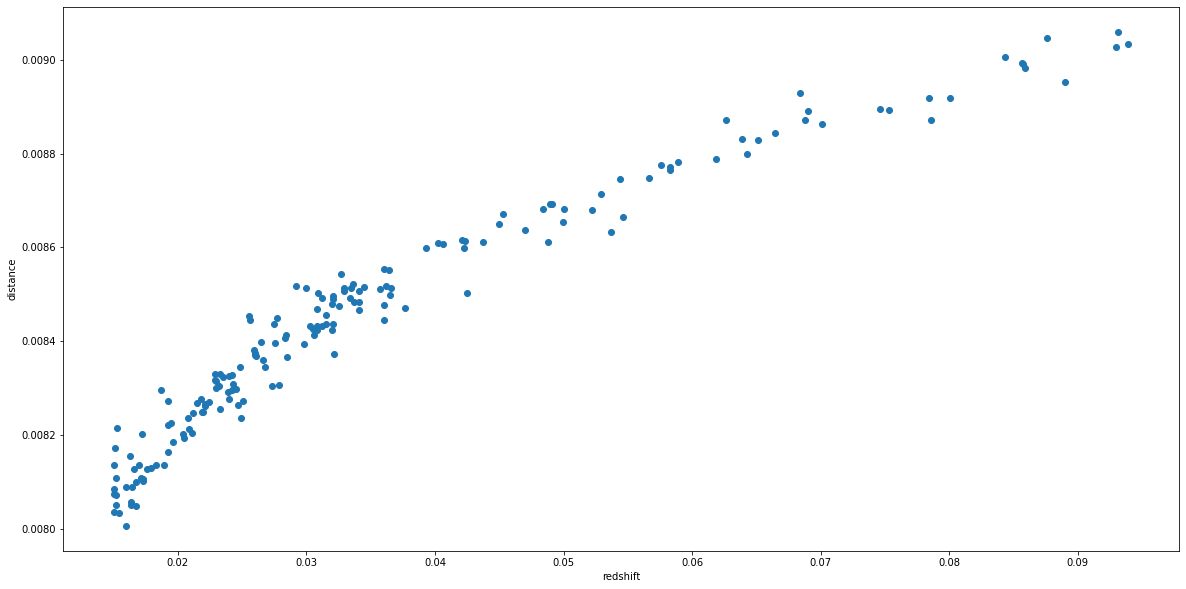

In [8]:
# We plot the distances vs redshift 
plt.scatter(z, distance) 
plt.xlabel('redshift')
plt.ylabel('distance')
plt.show()

We see that for low redshift z<<1 (we have considered the maximum redshift z = 0.01), the plot is linear. The slope will give us 71 ofcourse. This will the 0th order H_0. 

### H_0 using simple MCMC 

So far, we assumed the slope of the plot to be 71. Now we use MCMC to calculate this Hubble constant from the data- both 0th order and 1st order (see the notes for details). 

###### (Run one box - either 0th order or 1st order - at a time). 

MCMC stands for Markov Chain Monte Carlo and is a way to know the model for a given set of data - in our case to know the H_0 for a given set of SNIa data. The beginners tutorial (with solutions) by, Marcus Guffoggio (https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial_Solution.html) is easy to follow. We follow more or less the exact same steps.

MCMC includes the following things
1. Model - is a set of model parameters (we call this set theta) written as an expression - linear expression we have y = m x + c, with parameter m

2. Likelihood Function - we use a simple likelihood function as given the above reference

3. Prior - the boundary conditions to the input parameters

With these things in hand we run the MCMC on SNIa data 

#### 0th order approximation - Linear Hubble-Lemaitre Law

In [31]:
def model(theta,z=z): # model2
    m = theta
    return m * z + 0.008

#### 1st order approximation

In [10]:
def model(theta,z=z): # model1
    m = theta
    return m * z * (z + 1) + 0.008

Here again we are using simplest Likelihood function. But there are many other likelihood function specifically for Cosmology today. 

In [32]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

We can set prior for the slope. 1/m = H_0 - the range can be from 60km/sec/Mpc to 90km/sec/Mpc

In [33]:
def lnprior(theta):
    m = theta
    if 0.011 < m < 0.016:
        return 0.0
    return -np.inf

In [34]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [35]:
distance_err = 0.05 * np.mean(distance)
data = (z, distance,distance_err)
nwalkers = 128
niter = 500
initial = np.array([0.015])
ndim = len(initial)
p0 = [np.array(initial) + 1e-15 * np.random.randn(ndim) for i in range(nwalkers)]

In [36]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [37]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


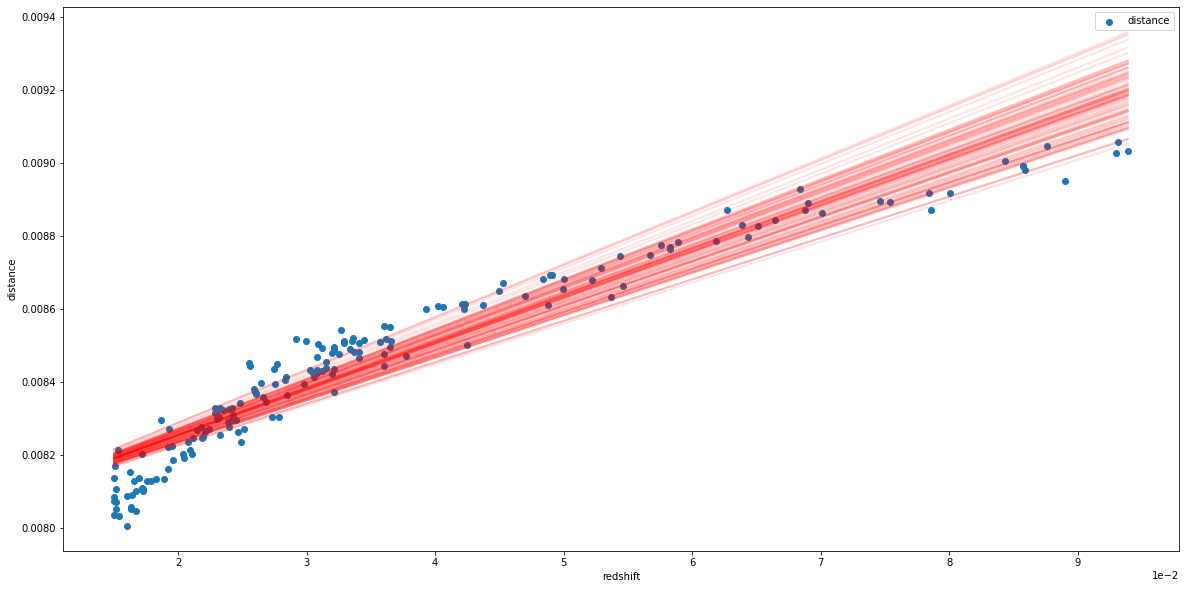

In [38]:
def plotter(sampler,z=z,distance=distance):
    plt.scatter(z,distance,label='distance')                                                 # distance vs z
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(z, model(theta, z), color="r", alpha=0.1)                                   # red lines
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('redshift')
    plt.ylabel('distance')
    plt.legend()
    plt.show()
    
#sampler= main(p0)
plotter(sampler)

In [39]:
samples = sampler.flatchain
best = samples[np.argmax(sampler.flatlnprobability)][0] # best value of theta
print(1/best)

79.21098339847116


To see the posterior probability distribution, we can make the following plot. We see that most probable value within redshift 0.1 is

A) 0th order - 79

B) 1st order - 84 (too high!)

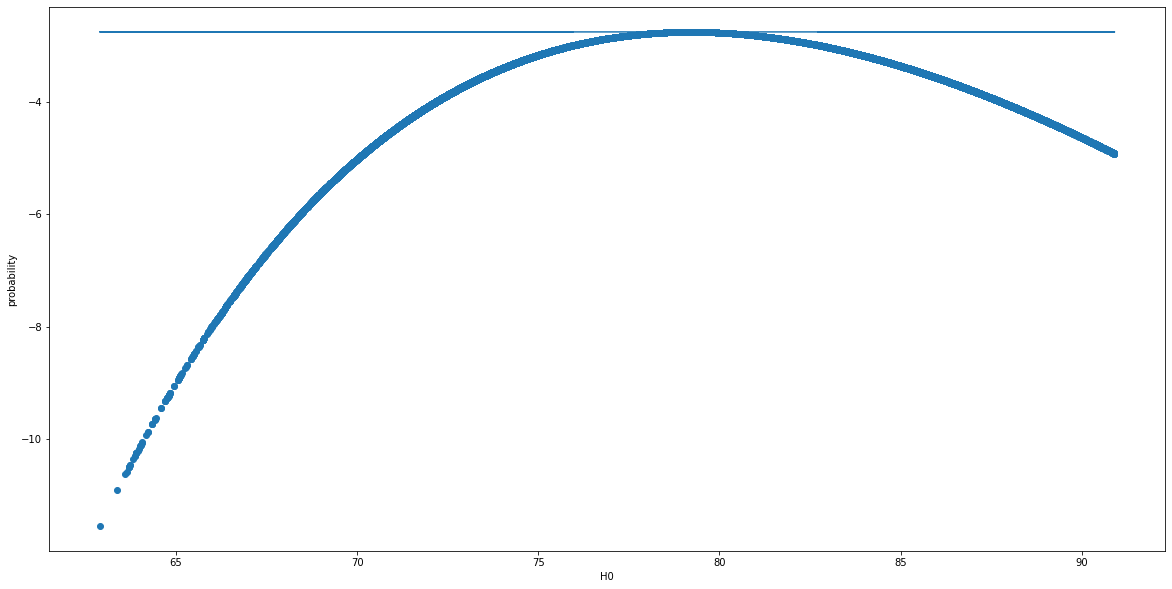

In [40]:
p = sampler.flatlnprobability # probability of different theta
plt.scatter(1/samples, p) # p vs H0
plt.plot(1/samples, p[np.argmax(p)] * np.ones(samples.shape[0])) # best selection
plt.xlabel('H0')
plt.ylabel('probability')
plt.show()

(3328, 1)


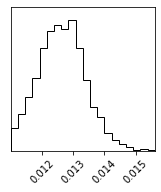

In [41]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples,
);